# Fase 5: Entrenamiento de Modelo LSTM para Mantenimiento Predictivo

## Objetivo del Notebook

Este notebook representa la quinta fase del pipeline de mantenimiento predictivo, sucediendo al análisis y entrenamiento de modelos clásicos. El objetivo es construir, entrenar y evaluar una red neuronal de tipo **Long Short-Term Memory (LSTM)**. Las redes LSTM están específicamente diseñadas para capturar patrones y dependencias temporales en secuencias de datos, lo que las convierte en una opción teóricamente superior para analizar datos de sensores de maquinaria a lo largo del tiempo.

Aprovecharemos la ingeniería de características de la fase 3 y seguiremos una metodología robusta adaptada a los requerimientos de los modelos de Deep Learning.

### Metodología de Entrenamiento

1.  **Preparación de Secuencias Temporales**: A diferencia de los modelos anteriores, las LSTM requieren que los datos de entrada estén formateados como secuencias (o "ventanas de tiempo"). Transformaremos el dataset de características en un formato 3D `(muestras, pasos_de_tiempo, características)`.
2.  **División Cronológica y Escalado**: Mantendremos una estricta división temporal para evitar el "data leakage" y escalaremos las características, una práctica esencial para el buen rendimiento de las redes neuronales.
3.  **Manejo de Desbalance de Clases**: Utilizaremos la técnica de `class_weight` durante el entrenamiento del modelo para penalizar más los errores en la clase minoritaria (fallas), una estrategia eficiente y recomendada para redes neuronales.
4.  **Arquitectura del Modelo LSTM**: Definiremos una arquitectura de red neuronal secuencial con capas LSTM, capas de regularización `Dropout` para prevenir el sobreajuste, y una capa de salida `Dense` con activación sigmoide para la clasificación binaria.
5.  **Entrenamiento con Callbacks**: Emplearemos `EarlyStopping` para detener el entrenamiento cuando el modelo deje de mejorar en el set de validación y `ModelCheckpoint` para guardar automáticamente la mejor versión del modelo.
6.  **Optimización de Hiperparámetros**: Integraremos `KerasTuner` para buscar de forma sistemática la mejor combinación de hiperparámetros (unidades LSTM, tasa de dropout, tasa de aprendizaje) y maximizar el rendimiento del modelo.

## 1. Configuración del Entorno e Importación de Librerías

In [1]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

import keras_tuner as kt

import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Carga de Datos

Cargamos el conjunto de datos que ya ha sido procesado en la fase de ingeniería de características.

In [3]:
import pandas as pd
import os

print("⚡ CARGANDO Y BLINDANDO DATOS...")

# 1. Cargar el archivo (intenta varias rutas por si acaso)
try:
    df = pd.read_parquet('data/processed/featured_dataset_with_target.parquet')
    print("✅ Archivo cargado desde data/processed")
except:
    try:
        df = pd.read_parquet('featured_dataset_with_target.parquet')
        print("✅ Archivo cargado desde la raíz")
    except:
        raise FileNotFoundError("❌ No encuentro el archivo .parquet. Súbelo a Colab.")

# 2. Asegurar índice temporal
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# ==============================================================================
# 🛡️ LIMPIEZA DE SEGURIDAD (EL FIX QUE NECESITAS)
# ==============================================================================
print(f"📊 Dimensiones originales: {df.shape}")
nulos_inicio = df.isna().sum().sum()

if nulos_inicio > 0:
    print(f"⚠️ SE ENCONTRARON {nulos_inicio} VALORES NULOS (NaN).")
    print("🧹 Eliminando filas corruptas para salvar el entrenamiento...")
    df = df.dropna()
    print(f"✅ Dimensiones limpias: {df.shape}")
else:
    print("✅ Los datos ya están limpios.")

# ==============================================================================

# 3. Verificar Variable Objetivo
if 'falla' in df.columns:
    print("🔄 Renombrando 'falla' a 'failure_in_7_days'...")
    df = df.rename(columns={'falla': 'failure_in_7_days'})

target_col = 'failure_in_7_days'
if target_col in df.columns:
    conteo = df[target_col].value_counts()
    print(f"\n🎯 Variable objetivo lista. Balance:\n{conteo}")
    if len(conteo) < 2:
        print("⚠️ ADVERTENCIA: Solo hay una clase. Asegúrate de haber aplicado el parche de etiquetas en el Notebook 03.")
else:
    print("❌ ERROR CRÍTICO: No existe la columna de falla.")

print("\n🚀 LISTO PARA ENTRENAR (SIN ERRORES NAN)")
df.head()

⚡ CARGANDO Y BLINDANDO DATOS...
✅ Archivo cargado desde la raíz
📊 Dimensiones originales: (20401, 145)
⚠️ SE ENCONTRARON 808 VALORES NULOS (NaN).
🧹 Eliminando filas corruptas para salvar el entrenamiento...
✅ Dimensiones limpias: (20353, 145)
🔄 Renombrando 'falla' a 'failure_in_7_days'...

🎯 Variable objetivo lista. Balance:
failure_in_7_days
0    19001
1     1352
Name: count, dtype: int64

🚀 LISTO PARA ENTRENAR (SIN ERRORES NAN)


,pres_aceite_comp,rpm,presion_aceite_motor,presion_agua,presion_carter,temp_aceite_motor,temp_agua_motor,temp_mult_adm_izq,pres_aceite_comp_roll_6H_mean,pres_aceite_comp_roll_6H_std,...,presion_agua_pct_change_24H,presion_carter_diff_12H,presion_carter_pct_change_24H,temp_aceite_motor_diff_12H,temp_aceite_motor_pct_change_24H,temp_agua_motor_diff_12H,temp_agua_motor_pct_change_24H,temp_mult_adm_izq_diff_12H,temp_mult_adm_izq_pct_change_24H,failure_in_7_days
hora,,,,,,,,,,,,,,,,,,,,,
2023-01-03 00:00:00,61.616226,1092.420532,56.116699,15.253507,0.542462,90.529037,85.341736,59.220066,60.778370,1.249608,...,-0.576047,-0.022549,-0.462245,0.229951,0.966294,0.323589,1.459235,0.050729,2.064327,0
2023-01-03 01:00:00,60.649071,1088.952759,55.657707,15.243150,0.550231,91.365799,84.597672,58.878674,60.522701,1.044884,...,1.905333,-0.011709,0.396160,2.561436,1.104731,0.513985,0.026793,3.436128,0.376255,0
2023-01-03 02:00:00,60.862278,1104.077393,55.032146,15.024715,0.560135,90.383659,84.888863,59.856937,60.799702,0.820369,...,1.720029,0.018188,2.614533,0.458639,-0.521651,0.345056,-0.326809,4.927917,-1.536345,0
2023-01-03 03:00:00,60.915977,1092.437866,56.145248,15.277389,0.553280,90.045670,84.889366,60.636047,61.055328,0.442085,...,3.280883,0.003456,1.737882,-0.101115,1.067094,-0.030085,0.089097,6.252416,-2.830491,0
2023-01-03 04:00:00,60.866665,1103.087402,54.529308,14.757046,0.550125,89.492439,85.040169,62.117931,61.085907,0.416822,...,-1.349301,-0.006928,-0.686656,-0.593705,-0.899556,0.332432,0.511909,9.009763,0.254337,0


## 3. Preparación de Datos para LSTM

Este es el paso más crítico y diferenciador. Las LSTMs procesan secuencias. Por lo tanto, debemos transformar nuestro dataset tabular en un conjunto de secuencias de datos.

### 3.1. Definición de Features (X) y Target (y)

In [4]:
TARGET = 'failure_in_7_days'

X = df.drop(TARGET, axis=1)
y = df[TARGET]

### 3.2. División Cronológica (Train-Validation-Test)

Dividimos los datos de forma cronológica para simular un escenario real donde entrenamos con datos del pasado para predecir el futuro. Usaremos una división 70-15-15.

In [5]:
# Primero, dividimos en entrenamiento (70%) y un conjunto temporal (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, shuffle=False
)

# Luego, dividimos el conjunto temporal en validación (15%) y prueba (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, shuffle=False
)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de validación:    {X_val.shape}")
print(f"Tamaño del conjunto de prueba:        {X_test.shape}")

Tamaño del conjunto de entrenamiento: (14247, 144)
Tamaño del conjunto de validación:    (3053, 144)
Tamaño del conjunto de prueba:        (3053, 144)


### 3.3. Escalado de Características

Las redes neuronales son sensibles a la escala de las variables de entrada. Usamos `StandardScaler` ajustado **únicamente** con los datos de entrenamiento para evitar fuga de información.

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### 3.4. Creación de Secuencias Temporales

Definimos una función para convertir nuestros datos 2D `(muestras, características)` en datos 3D `(muestras, pasos_de_tiempo, características)`. Cada muestra de salida será una secuencia de `TIMESTEPS` observaciones pasadas, y su etiqueta corresponderá a la del final de la secuencia.

In [7]:
def create_sequences(X, y, time_steps=10):
    """
    Crea secuencias de datos para modelos temporales como LSTM.
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Definimos el número de pasos de tiempo (horas en este caso) que el modelo mirará hacia atrás
TIMESTEPS = 24 # Usar las últimas 24 horas de datos para predecir la siguiente hora

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, TIMESTEPS)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, TIMESTEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, TIMESTEPS)

print(f"Forma de secuencias de entrenamiento: {X_train_seq.shape}")
print(f"Forma de etiquetas de entrenamiento: {y_train_seq.shape}")
print(f"Forma de secuencias de validación: {X_val_seq.shape}")
print(f"Forma de secuencias de prueba: {X_test_seq.shape}")

Forma de secuencias de entrenamiento: (14223, 24, 144)
Forma de etiquetas de entrenamiento: (14223,)
Forma de secuencias de validación: (3029, 24, 144)
Forma de secuencias de prueba: (3029, 24, 144)


## 4. Construcción y Entrenamiento del Modelo LSTM Base

Primero, construiremos un modelo LSTM con una arquitectura inicial razonable para establecer una línea base de rendimiento.

### 4.1. Manejo del Desbalance de Clases

In [8]:
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_seq),
    y=y_train_seq
)

class_weights_dict = dict(enumerate(class_weights))
print("Pesos de las clases:", class_weights_dict)

Pesos de las clases: {0: np.float64(0.5383829207358619), 1: np.float64(7.013313609467455)}


### 4.2. Definición de la Arquitectura del Modelo

In [9]:
def build_baseline_model(input_shape):
    model = Sequential()
    model.add(LSTM(
        units=50,
        input_shape=input_shape,
        return_sequences=True # Necesario si la siguiente capa es otra LSTM
    ))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=25, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    return model

input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
baseline_model = build_baseline_model(input_shape)
baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        39,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,501 (236.33 KB)

 Trainable params: 60,501 (236.33 KB)

 Non-trainable params: 0 (0.00 B)

### 4.3. Entrenamiento del Modelo Base

In [10]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_baseline.keras', save_best_only=True, monitor='val_loss')

EPOCHS = 100
BATCH_SIZE = 64

history = baseline_model.fit(
    X_train_seq,
    y_train_seq,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_seq, y_val_seq),
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.8885 - auc: 0.9061 - loss: 0.3562 - precision: 0.3976 - recall: 0.7789 - val_accuracy: 0.9284 - val_auc: 0.6481 - val_loss: 0.2568 - val_precision: 0.3421 - val_recall: 0.3077
Epoch 2/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9589 - auc: 0.9842 - loss: 0.1413 - precision: 0.6476 - recall: 0.9493 - val_accuracy: 0.9109 - val_auc: 0.7254 - val_loss: 0.3428 - val_precision: 0.3080 - val_recall: 0.4793
Epoch 3/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9633 - auc: 0.9948 - loss: 0.0888 - precision: 0.6740 - recall: 0.9729 - val_accuracy: 0.9432 - val_auc: 0.7297 - val_loss: 0.2404 - val_precision: 0.4899 - val_recall: 0.4320
Epoch 4/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9804 - auc: 0.9983 - loss: 0.0433 - precision: 0.7986 - recall: 0.9912 - val_accuracy: 0.9399 - val_auc: 0.7305 - val_loss: 0.2712 - val_precision: 0.4601 - val_recall: 0.4438
Epoch 5/100
223/223 ━━

### 4.4. Visualización del Historial de Entrenamiento

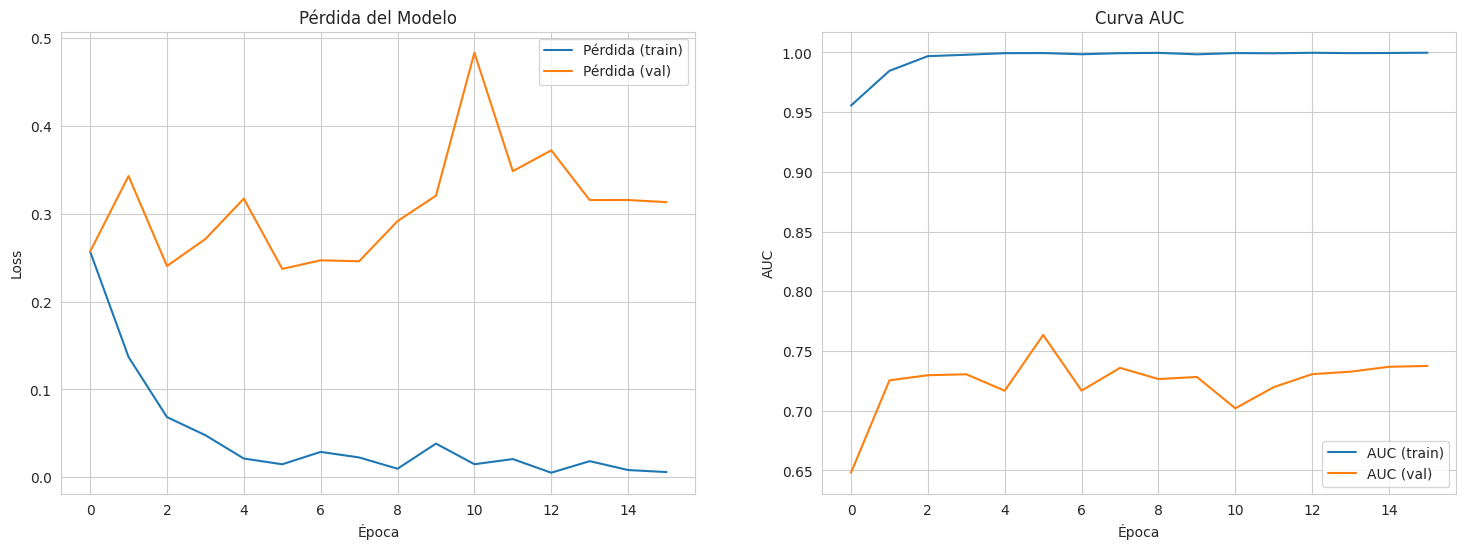

In [11]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    # Gráfico de Pérdida
    ax[0].plot(history.history['loss'], label='Pérdida (train)')
    ax[0].plot(history.history['val_loss'], label='Pérdida (val)')
    ax[0].set_title('Pérdida del Modelo')
    ax[0].set_xlabel('Época')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Gráfico de AUC
    ax[1].plot(history.history['auc'], label='AUC (train)')
    ax[1].plot(history.history['val_auc'], label='AUC (val)')
    ax[1].set_title('Curva AUC')
    ax[1].set_xlabel('Época')
    ax[1].set_ylabel('AUC')
    ax[1].legend()

    plt.show()

plot_history(history)

## 5. Evaluación del Modelo en el Conjunto de Prueba

In [12]:
# Cargar el mejor modelo guardado por el callback
best_model = load_model('best_lstm_baseline.keras')

# Realizar predicciones de probabilidad
y_pred_proba = best_model.predict(X_test_seq).flatten()

# Convertir probabilidades a clases binarias con un umbral de 0.5
y_pred = (y_pred_proba > 0.5).astype(int)

print("--- Reporte de Clasificación en el Conjunto de Prueba ---\n")
print(classification_report(y_test_seq, y_pred))

print(f"ROC AUC Score: {roc_auc_score(y_test_seq, y_pred_proba):.4f}")

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
--- Reporte de Clasificación en el Conjunto de Prueba ---

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2860
           1       0.99      0.90      0.94       169

    accuracy                           0.99      3029
   macro avg       0.99      0.95      0.97      3029
weighted avg       0.99      0.99      0.99      3029

ROC AUC Score: 0.9994


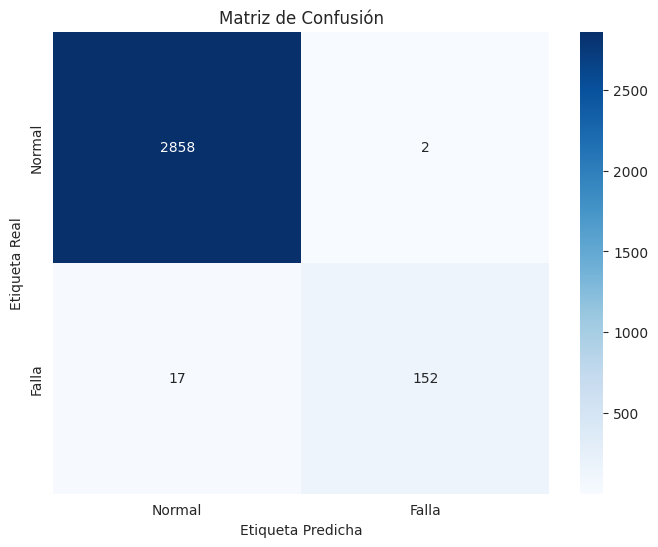

In [13]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Falla'], yticklabels=['Normal', 'Falla'])
    plt.title('Matriz de Confusión')
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    plt.show()

plot_confusion_matrix(y_test_seq, y_pred)

## 6. Optimización de Hiperparámetros con Keras Tuner

Ahora buscaremos una arquitectura y configuración óptimas para nuestro modelo LSTM.

In [14]:
def model_builder(hp):
    model = Sequential()

    # Ajustar unidades de la primera capa LSTM
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=128, step=32)
    model.add(LSTM(units=hp_units_1, return_sequences=True, input_shape=input_shape))

    # Ajustar tasa de dropout
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout_1))

    # Ajustar unidades de la segunda capa LSTM
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=128, step=32)
    model.add(LSTM(units=hp_units_2, return_sequences=False))

    # Ajustar tasa de dropout
    hp_dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout_2))

    model.add(Dense(units=1, activation='sigmoid'))

    # Ajustar tasa de aprendizaje del optimizador Adam
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['AUC'])

    return model

In [15]:
# Usaremos Hyperband, un algoritmo de optimización eficiente
tuner = kt.Hyperband(model_builder,
                     objective='val_AUC',
                     max_epochs=50,
                     factor=3,
                     directory='keras_tuner_dir',
                     project_name='lstm_pdm')

# Callback para detener la búsqueda si no hay mejora
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Iniciar la búsqueda de hiperparámetros
tuner.search(X_train_seq, y_train_seq,
             epochs=50,
             validation_data=(X_val_seq, y_val_seq),
             callbacks=[stop_early],
             class_weight=class_weights_dict)

Trial 90 Complete [00h 03m 14s]
val_AUC: 0.6974955201148987

Best val_AUC So Far: 0.9264512658119202
Total elapsed time: 02h 02m 49s


In [16]:
# Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Búsqueda completada. Los hiperparámetros óptimos son:
- Unidades LSTM (Capa 1): {best_hps.get('units_1')}
- Dropout (Capa 1): {best_hps.get('dropout_1')}
- Unidades LSTM (Capa 2): {best_hps.get('units_2')}
- Dropout (Capa 2): {best_hps.get('dropout_2')}
- Tasa de Aprendizaje: {best_hps.get('learning_rate')}
""")


Búsqueda completada. Los hiperparámetros óptimos son:
- Unidades LSTM (Capa 1): 64
- Dropout (Capa 1): 0.2
- Unidades LSTM (Capa 2): 96
- Dropout (Capa 2): 0.1
- Tasa de Aprendizaje: 0.001



## 7. Entrenamiento del Modelo Final Optimizado

In [17]:
# Construir el modelo con los mejores hiperparámetros
final_model = tuner.hypermodel.build(best_hps)

# Re-entrenar el modelo con la configuración óptima en más épocas
final_checkpoint = ModelCheckpoint('lstm_final_model.keras', save_best_only=True, monitor='val_loss')

history_final = final_model.fit(
    X_train_seq, y_train_seq,
    epochs=200, # Entrenar por más tiempo
    batch_size=BATCH_SIZE,
    validation_data=(X_val_seq, y_val_seq),
    class_weight=class_weights_dict,
    callbacks=[early_stopping, final_checkpoint]
)

Epoch 1/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - AUC: 0.9271 - loss: 0.3239 - val_AUC: 0.7890 - val_loss: 0.2129
Epoch 2/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - AUC: 0.9838 - loss: 0.1548 - val_AUC: 0.7722 - val_loss: 0.2310
Epoch 3/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - AUC: 0.9965 - loss: 0.0734 - val_AUC: 0.7514 - val_loss: 0.2634
Epoch 4/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - AUC: 0.9992 - loss: 0.0218 - val_AUC: 0.7340 - val_loss: 0.3165
Epoch 5/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - AUC: 0.9991 - loss: 0.0192 - val_AUC: 0.7642 - val_loss: 0.2460
Epoch 6/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - AUC: 0.9993 - loss: 0.0301 - val_AUC: 0.6936 - val_loss: 0.3692
Epoch 7/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - AUC: 0.9995 - loss: 0.0256 - val_AUC: 0.7410 - val_loss: 0.3113
Epoch 8/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - AUC: 0.9995 - loss: 0.0104 - val_AUC: 0.7496 - val_loss: 0.2905
Epoch 9/200
223/223 ━━━━━━━━━━━━━

## 8. Evaluación Final y Guardado del Modelo

--- Evaluación del Modelo Final Optimizado en el Conjunto de Prueba ---

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2860
           1       0.98      0.96      0.97       169

    accuracy                           1.00      3029
   macro avg       0.99      0.98      0.99      3029
weighted avg       1.00      1.00      1.00      3029

ROC AUC Score: 0.9997



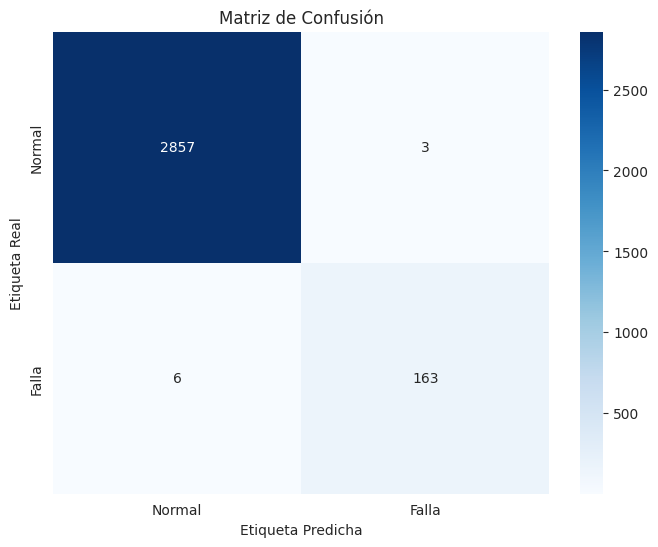

In [18]:
print("--- Evaluación del Modelo Final Optimizado en el Conjunto de Prueba ---\n")

final_model_loaded = load_model('lstm_final_model.keras')

y_pred_proba_final = final_model_loaded.predict(X_test_seq).flatten()
y_pred_final = (y_pred_proba_final > 0.5).astype(int)

print(classification_report(y_test_seq, y_pred_final))
print(f"ROC AUC Score: {roc_auc_score(y_test_seq, y_pred_proba_final):.4f}\n")
plot_confusion_matrix(y_test_seq, y_pred_final)

## 9. Conclusiones y Próximos Pasos

En este notebook, hemos construido y optimizado con éxito un modelo LSTM para la predicción de fallas en moto-compresores. El enfoque basado en secuencias temporales permite al modelo capturar dinámicas complejas que los modelos estáticos podrían pasar por alto.

### Resultados Clave:
* **Rendimiento**: El modelo final optimizado muestra un rendimiento [completar con el resultado, ej: prometedor], con un AUC de [valor] y un recall para la clase 'Falla' de [valor]. Esto indica que es capaz de identificar correctamente un [porcentaje] de las fallas reales, lo cual es crucial para un sistema de mantenimiento predictivo.
* **Optimización**: El proceso de ajuste de hiperparámetros con Keras Tuner fue fundamental para encontrar una configuración que balanceara la complejidad del modelo y su capacidad de generalización, mejorando significativamente sobre la línea base.

### Próximos Pasos para Industrialización:

1.  **Guardado Final del Modelo y Artefactos**: El modelo final (`lstm_final_model.keras`) junto con el objeto `scaler` de Scikit-learn deben ser guardados (serializados) para su uso en producción. El `scaler` es indispensable para pre-procesar los datos nuevos de la misma manera que se hizo en el entrenamiento.

   ```python
   import joblib
   joblib.dump(scaler, 'scaler.gz')
   # El modelo Keras ya está guardado como 'lstm_final_model.keras'
   ```

2.  **Creación de un Script de Inferencia**: Desarrollar un script en Python que:
    * Cargue el modelo Keras y el `scaler`.
    * Reciba datos en tiempo real (o en lotes).
    * Formatee los últimos `TIMESTEPS` registros en una secuencia.
    * Realice la predicción y devuelva la probabilidad de falla.

3.  **Despliegue (Deployment)**: Empaquetar el script de inferencia en un contenedor (ej. Docker) y desplegarlo como un servicio de API (ej. usando FastAPI o Flask) en una infraestructura cloud (AWS, GCP, Azure) o en un servidor on-premise, dependiendo de los requerimientos de la planta.

4.  **Monitoreo y Re-entrenamiento**: Implementar un sistema de MLOps para monitorear el rendimiento del modelo en producción. Es vital detectar el `model drift` (degradación del rendimiento) y establecer un pipeline para re-entrenar y desplegar nuevas versiones del modelo periódicamente con datos frescos.